# 앞서 해봤던 인물사진 모드의 문제점 찾기

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

import os
from importlib.metadata import version
import cv2
import numpy as np
import urllib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## 사진 불러오기  


(1440, 1082, 3)
(653, 640, 3)
(1392, 744, 3)


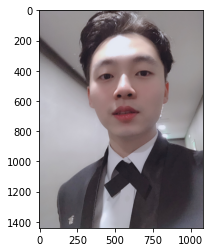

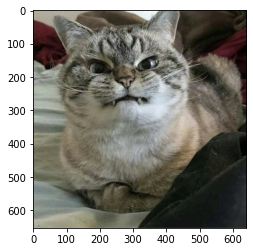

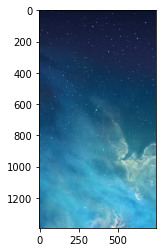

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'  
img_orig1 = cv2.imread(img_path + '/self1.jpg') 
img_orig2 = cv2.imread(img_path + '/cat.jpg') 
img_orig3 = cv2.imread(img_path + '/bg.jpg') 

print(img_orig1.shape)
print(img_orig2.shape)
print(img_orig3.shape)


plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# # 모델이 이미 다운로드 되어 있으므로 다운로드 과정은 건너뛰고 변수에 불러오기만 함

# # 저장할 파일 이름을 결정합니다
# # 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# # 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장

# # 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# # 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# # PixelLib가 제공하는 모델의 url입니다
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# # 다운로드를 시작합니다
# urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

### 세그멘테이션 모델 생성
pascalvoc을 이용한 모델을 사용할 예정

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

## 첫번째 이미지
모델에 첫번째 이미지를 입력

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path + '/self1.jpg')

현재 pascalvoc에는 background를 제외한 20개의 클래스가 존재하며,
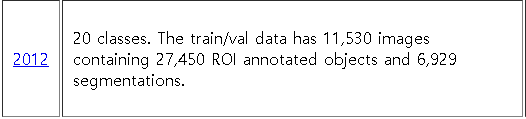
그 클래스를 리스트로 만들었다.  
background를 0번 인덱스로 시작하여 총 21개의 클래스가 된다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

우리가 사용해서 추출을 진행할 인덱스는 person 15번 인덱스이다

<function matplotlib.pyplot.show(close=None, block=None)>

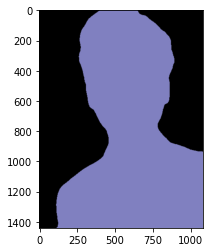

In [7]:
plt.imshow(output)
plt.show

깔끔하게 나왔다.  
위에서 pascalvoc 모델에 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력  
0과 15만 출력되었다는건 0번 인덱스인 background와 15번 인덱스인 person만 이미지에서 분류되었다는 뜻

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output으로 나온 색상들이 어떤 물체인지 알아내는 방법도 있다.  
아래 colormap은 각 내부 리스트로 나온 수치는 인덱스 순서 별 RGB을 나타냄  
그러나 output으로 나온 색상들은 BGR 색 영역으로 이루어져있어 BGR로 바꿔주는 작업이 필요하다.

In [10]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]           # 15번 인덱스는 person 사람을 뜻함, RGB

array([192, 128, 128])

In [12]:
seg_color = (colormap[15][2], colormap[15][1], colormap[15][0])
seg_color

(128, 128, 192)

### output에서 나온 픽셀 별 색상이 seg_color와 같다면 1(True) 다르면 0(False)가 된다.
그러므로 사람이 있는 위치를 제외하고는 gray로 출력된다  
plt.show 인자 cmap에 다른 색을 입력하면 그 색을 따른다.

(1440, 1082)


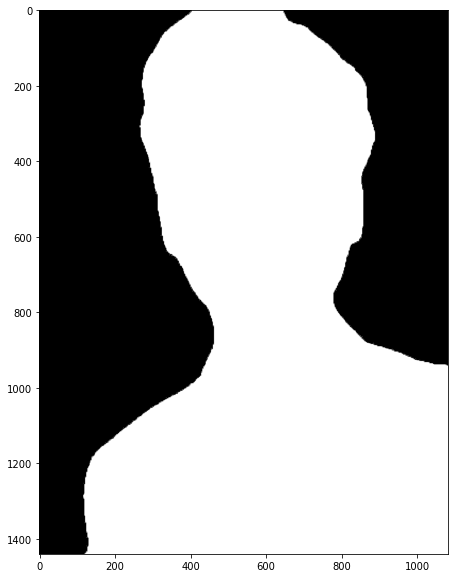

In [13]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.subplots(figsize=(15, 10))
plt.imshow(seg_map, cmap='gray')
plt.show()

위 결과물과 원본 이미지를 겹쳐서 잘 추출되었는지 확인해보자

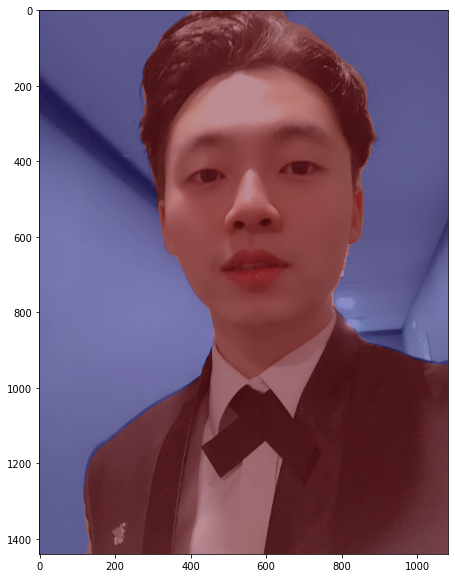

In [14]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

blur() 함수를 사용하여 배경을 흐리게 만들기

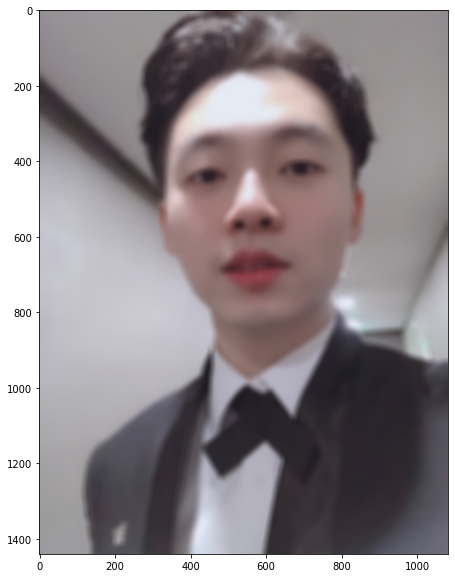

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 값이 클수록 블러의 강도가 세짐
img_orig_blur = cv2.blur(img_orig1, (20,20))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출  
위에서 구한 person 영역을 검은색으로 바꾸고 출력하는것

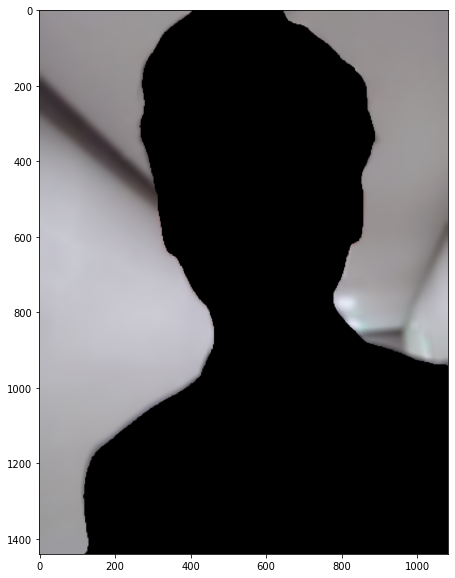

In [16]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

배경을 블러 처리한 이미지와 인물 이미지를 합치기

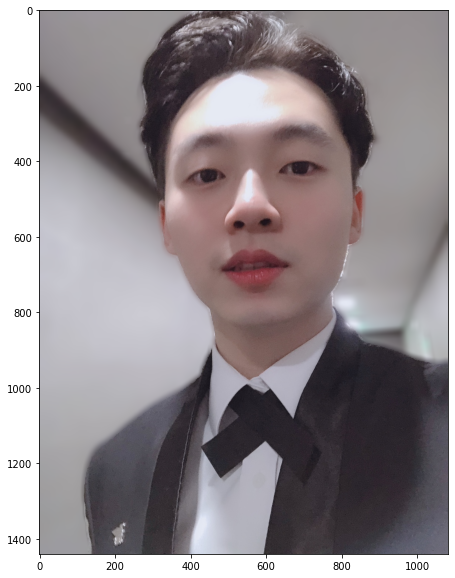

In [17]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig1, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분(검은색)만 원본 이미지를 가져오고 아닌 영역은 블러 이미지 값 사용  
np.where(조건, 참일때, 거짓일때)형식 코드 사용
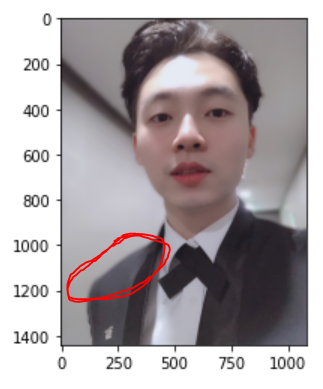
첫번째 사진은 어깨 선에 살짝 블러처리가 된듯한 오류가 보인다.

### 두번째 이미지
두번째 이미지를 모델에 입력

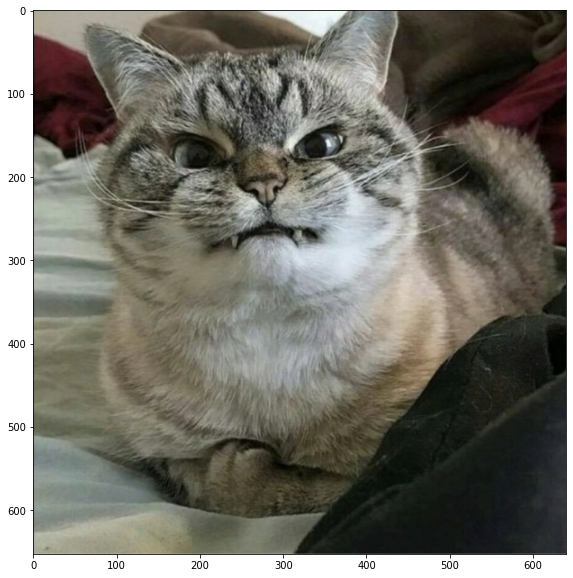

In [18]:
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

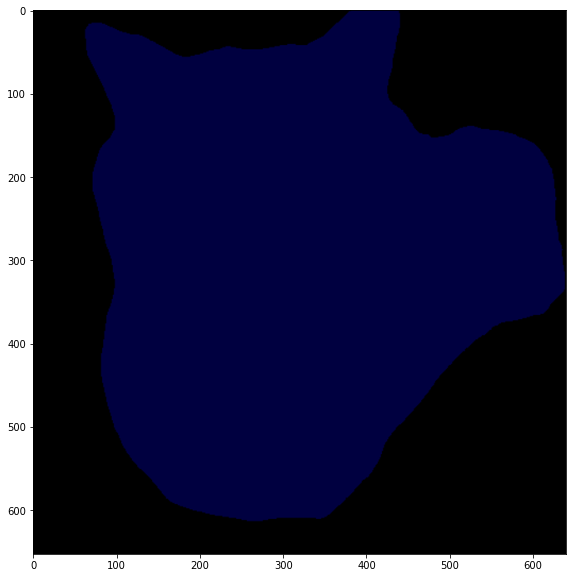

In [19]:
segvalues, output = model.segmentAsPascalvoc(img_path + '/cat.jpg')

plt.subplots(figsize=(15, 10))
plt.imshow(output)
plt.show

고양이의 실루엣이 보이는군요!

In [20]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [21]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


background와 cat을 정확히 분류했습니다

In [22]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [23]:
print(colormap[8])

[64  0  0]


In [24]:
seg_color = (colormap[8][2], colormap[8][1], colormap[8][0])
print(seg_color)

(0, 0, 64)


(653, 640)


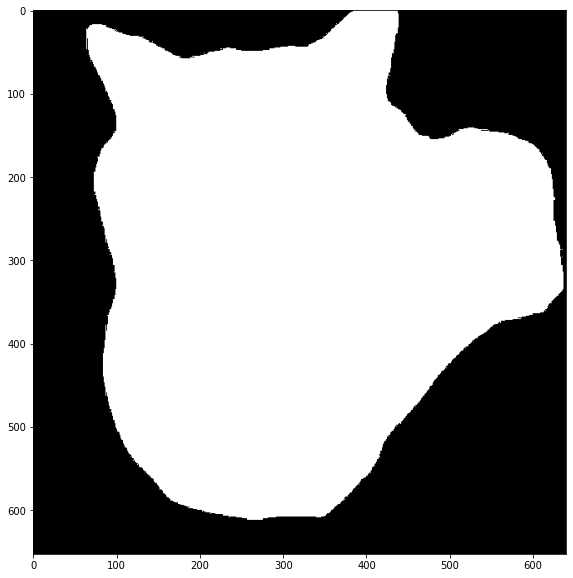

In [25]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.subplots(figsize=(15, 10))
plt.imshow(seg_map, cmap='gray')
plt.show()

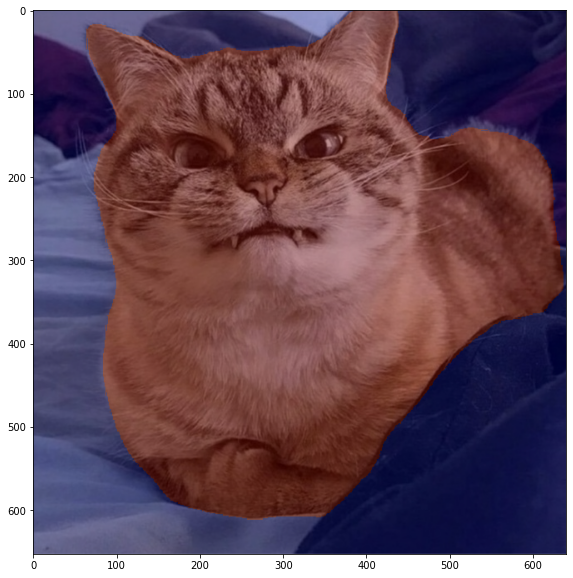

In [26]:
img_show = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255


# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)


plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

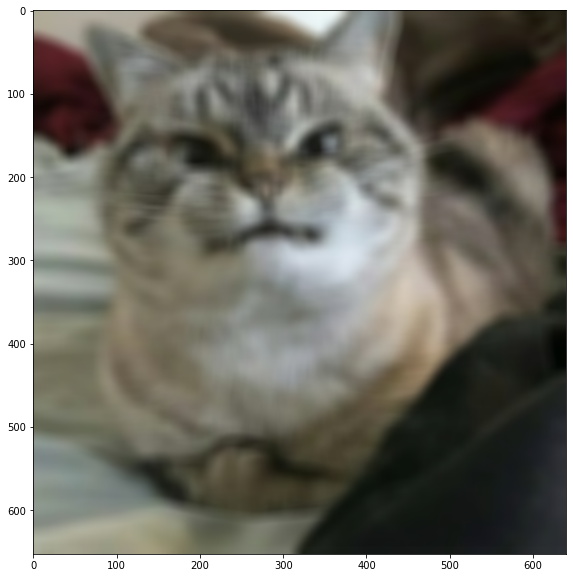

In [27]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요    - 값이 클수록 블러의 강도가 세짐
img_orig_blur = cv2.blur(img_orig2, (17,17))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

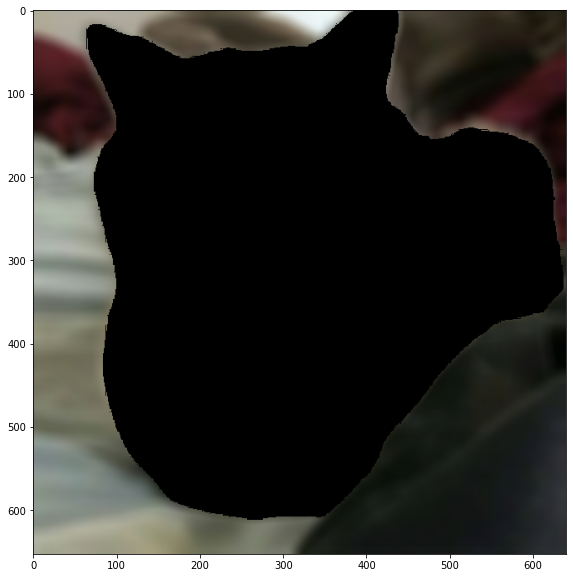

In [28]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show(1)
# img_bg_blur= cv2.addWeighted(img_bg_blur1, 0.5, img_bg_blur2, 0.5, 1.0)
# plt.subplots(figsize=(15, 10))
# plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
# plt.show()

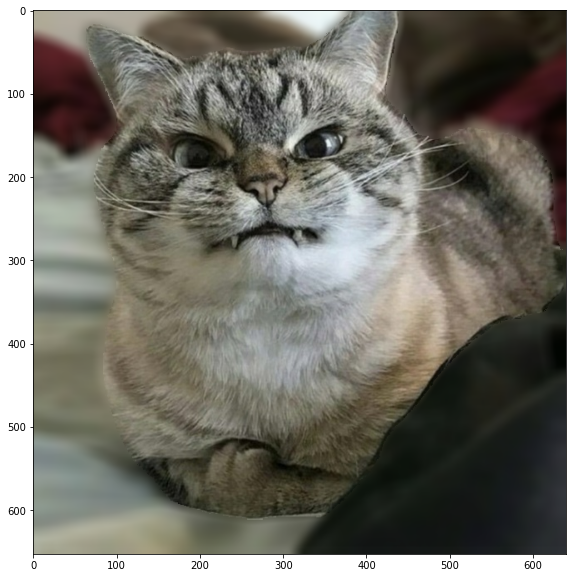

In [29]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

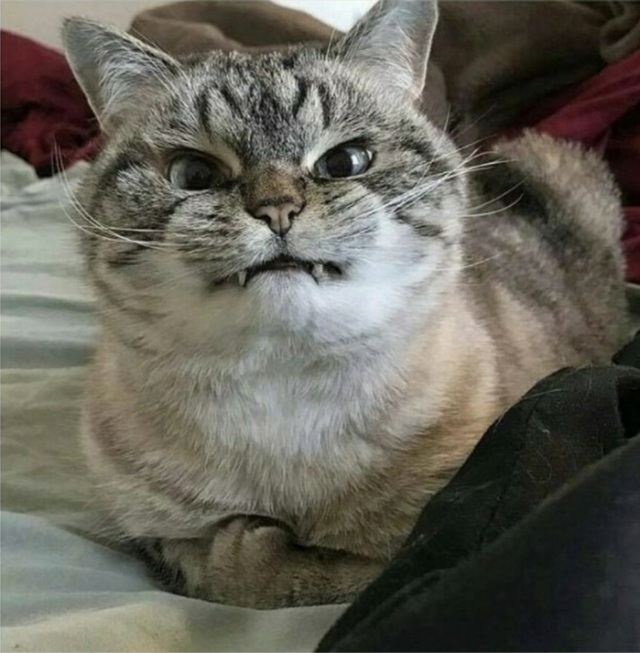

원본과 비교했을때 생각보다 완성도가 높다고 생각했다  
오른쪽 아래의 검은색 물체도 블러처리가 잘 되었다  
다만 고양이 수염이 잘려나간게 마음이 아프다.

### 두번째 이미지의 객채를 세번째 이미지의 배경에 넣기

(653, 640)


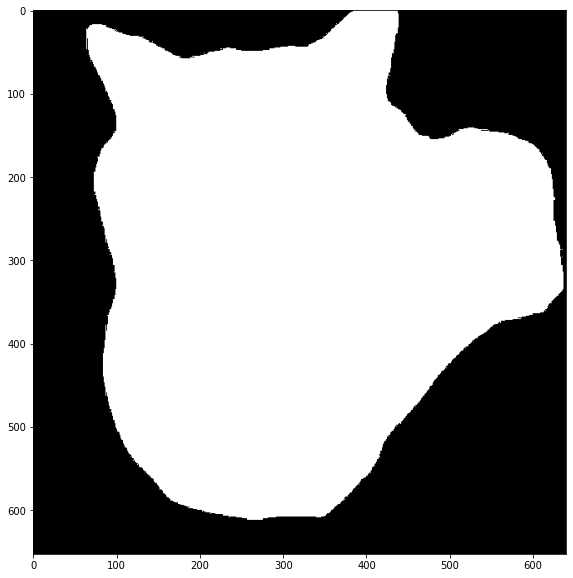

In [30]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.subplots(figsize=(15, 10))
plt.imshow(seg_map, cmap='gray')
plt.show()

배경 이미지의 크기를 조정해주어야한다.

In [33]:
img_orig3 = cv2.resize(img_orig3, (640,653)) # 배경 이미지 조정
img_orig3.shape

(653, 640, 3)

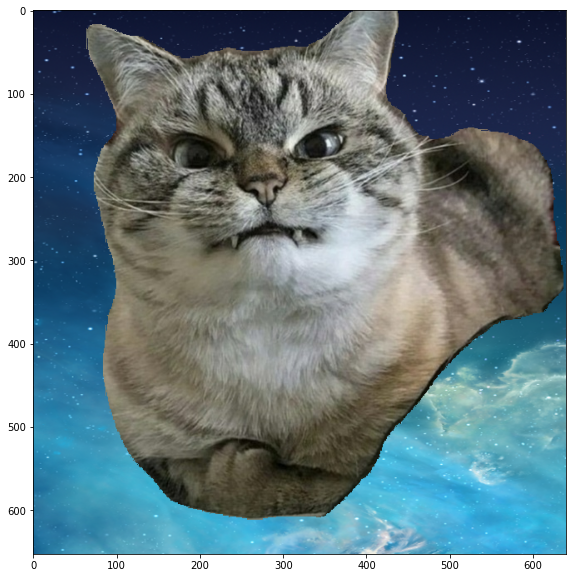

In [34]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig2, img_orig3)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

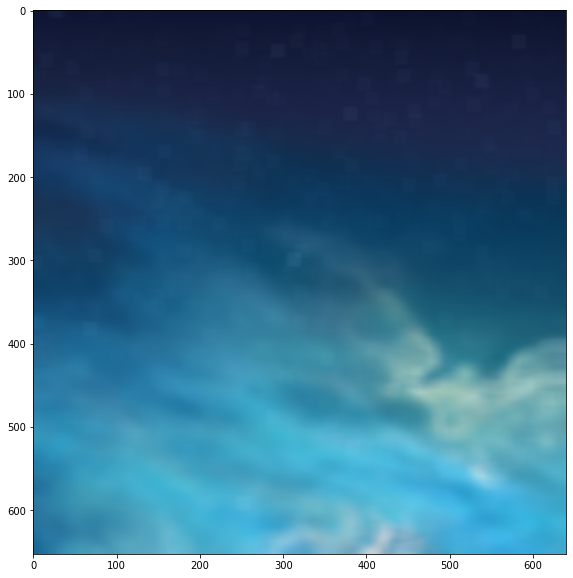

In [35]:
img_orig_blur = cv2.blur(img_orig3, (17,17))

plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

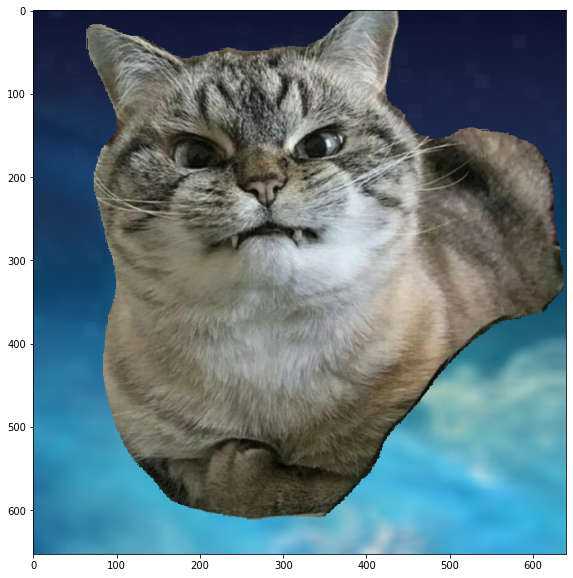

In [36]:
img_concat = np.where(img_mask_color==255, img_orig2, img_orig_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.subplots(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 이미지 작업은 재밌어,,,